# Problem 1: Data with R

In [63]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [64]:
%%R

library(tidyverse)

In [65]:
%%R
# make sure to get your data in the same folder, next to the notebook file
# so that this will run!


dat <- read_csv('classification_data.csv')

/opt/conda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Parsed with column specification:
cols(
  X = col_double(),
  label = col_integer()
)

  warnings.warn(x, RRuntimeWarning)


In [66]:
#%%R

#factor_label <- factor(dat["label"])

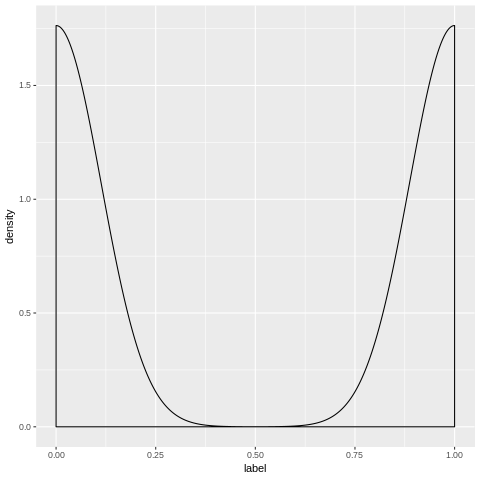

In [67]:
%%R

# Your data consists of an "X" column and a "label" column
# Use ggplot to plot a kernel density estimate of each label (overlayed on the same plot)
# hint: don't forget to make sure the labels are factors!

ggplot(dat, aes(label)) +
  geom_density()

# Problem 2: Using Classes in Python

In [68]:
from abc import ABC, abstractmethod
from math import sqrt

def smart_zip(a,b):
    try:
        return zip(a, b)
    except TypeError:
        return zip([a], [b])

class AbstractKNeighbors(ABC):
    def __init__(self, K):
        self.K = K

    def fit(self, X, y):
        """ Train the model!

        X should be a list of data points
        y should be a list of labels
        """
        self.X = X
        self.y = y
        return self

    @abstractmethod
    def _make_prediction(self, labels):
        pass

    def predict(self, new_x):
        """Find the nearest K neighbors
        
        new_x should be a single data point
        """

        dists = [sqrt(sum(([(i-j)**2 for i,j in smart_zip(x,new_x)])))
                 for x in self.X]
        sorted_neighbors = sorted(enumerate(dists),
                                  key=lambda t: t[1])
        labels = [self.y[i] for i,_ in sorted_neighbors]
        return self._make_prediction(labels)


class KNearestNeighbors(AbstractKNeighbors):
    def _make_prediction(self, labels):
        avg = sum(labels[:self.K])/self.K
        return round(avg)

class KFurthestNeighbors(AbstractKNeighbors):
    def _make_prediction(self, labels):
        avg = sum(labels[-self.K:])/self.K
        return round(1 - avg)

In [69]:
from csv import reader

with open('classification_data.csv', 'r') as f:
    dat = list(reader(f))[1:]
    dat = [[float(x), int(label)] for x,label in dat]

## Problem 2.1: Shuffling!

In [70]:
# In your data, "X" is a data point that is nothing more than
# a single number. 
# Shuffle your data into a random order (use random.shuffle!)

import random

random.shuffle(dat)

In [71]:
# If you shuffled your data, this test should pass
# (i.e. not throw an error)

assert(sum([label for x,label in dat[:50]]) != 0)

## Problem 2.2: Splitting!

In [72]:
# Split your data, which is now a list, into 2 sublists:
# "train" and "test"
# The "train" group should have 700 elements
# The test group should have 300 elements
# Each group should have the same format as the original data

train = dat[:700]
test = dat[700:]

In [73]:
# Now you will need to make another split, within the groups!
# For each group ("train" and "test") split the X's from the labels.

train_x = [item[0] for item in train]
train_label = [item[1] for item in train]

test_x = [item[0] for item in test]
test_label = [item[1] for item in test]

## Problem 2.3: Testing models!

In [75]:
# For each model: 
# 1. Create an instance the class, with constructor parameters: K=5

class Training_X:
    def KNearestNeighbors(self, X, K):
        self.X = X
        self.K = 5

class Training_label:
    def KNearestNeighbors(self, label, K):
        self.label = label
        self.K = 5
    
# 2. Train the instance on the "train" groups X's and labels (y's)

Training_X(train_x)
Training_label(train_label)

# 3. Test how well the instance does: 
#    A. Use the trained instance to predict the label of each "X" in the "test" group
#    B. Use your "test" labels to see if the predicted label is equal the true label



TypeError: object() takes no parameters

In [ ]:
# Compare the two classes of models!